In [19]:
%matplotlib inline

import time

import pandas
import numpy
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.linear_model

In [85]:
# Return a combined DataFrame, and a dictionary of {featuretype: columns}
def load_data(filename):
    def load_sheet(name):
        df = file.parse(name)
        if 'Index' in df.columns:
            # we index based on row number
            del df['Index']
        else:
            # remove duplicated labels
            del df['Labels']
        return df
    
    file = pandas.ExcelFile(filename)
    dfs = { sheet: load_sheet(sheet) for sheet in file.sheet_names}
    
    # AMT is missing names for columns
    combine = [dfs[k] for k in dfs.keys() if k not in ('AMT')]
    
    combined = dfs['AMT'].copy().add_suffix('-AMT')
    combined = combined.join(combine, lsuffix='', rsuffix='')
    
    # TODO: there are also categories within each wavelet series
    # separated with a _ or -
    feature_categories = {}
    for category, df in dfs.items():
        columns = df.columns
        feature_categories[category] = columns
    
    return combined, feature_categories

fulldata, categories = load_data('DAT300 - CA 1_NEW.xlsx')
assert fulldata.shape[0] == 120, fulldata.shape
assert numpy.count_nonzero(fulldata.Labels.isnull()) == 0, numpy.count_nonzero(fulldata.Labels.isnull())


In [108]:
categories.keys()

dict_keys(['Target', 'AMT', 'WT_originals', 'WT-LLL', 'WT-LLH', 'WT_LHL', 'WT_LHH', 'LBP'])

In [109]:
fulldata.head()

,1-AMT,2-AMT,3-AMT,4-AMT,5-AMT,6-AMT,7-AMT,8-AMT,9-AMT,10-AMT,...,"lbp_24_(24,3)","lbp_25_(24,3)","lbp_2_(24,3)","lbp_3_(24,3)","lbp_4_(24,3)","lbp_5_(24,3)","lbp_6_(24,3)","lbp_7_(24,3)","lbp_8_(24,3)","lbp_9_(24,3)"
0,1.55144,1.51980,1.45847,1.43940,1.43263,1.44893,1.50741,1.54977,1.59866,1.63075,...,53695,468638,17261,15439,18953,22857,24262,26894,27454,29276
1,1.51458,1.47539,1.45449,1.46195,1.44090,1.47846,1.51607,1.53459,1.51287,1.54192,...,53047,462418,16941,15294,18823,22369,24826,27250,28437,30374
2,1.50565,1.46602,1.44400,1.45143,1.42508,1.41574,1.44243,1.47648,1.44198,1.45998,...,53917,469225,17328,15441,19056,22997,24702,26641,27585,29121
3,1.53664,1.50323,1.46508,1.42571,1.43470,1.42078,1.44322,1.45240,1.46457,1.51837,...,53643,465916,16694,15318,18830,22634,24608,26706,27805,29507
4,1.52808,1.47522,1.45618,1.37537,1.37561,1.39346,1.42378,1.46455,1.47553,1.46507,...,48987,456795,15882,14244,17120,20866,23471,26877,28607,31338


In [6]:
fulldata.shape

(128, 1426)

In [98]:
def get_XY(data, feature_columns=None):
    all_feature_columns = list(set(data.columns) - set(['Labels']))
    
    use = data[data.Labels.notna()]
    X = use[all_feature_columns].astype(float)
    if feature_columns:
        print('f', feature_columns, X.shape)
        X = X.iloc[:,feature_columns]
    y = use.Labels
    return X,y

In [52]:
def feature_score_rf(X, y, n_reps=30):
    importances = numpy.ndarray((n_reps, X.shape[1]))
    # RF tends to ignore redundant features, so average over many runs
    for i in range(0, n_reps):
        rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, random_state=i)
        rf.fit(X, y)
        s = rf.feature_importances_
        importances[i] = s
        assert numpy.isclose(numpy.sum(s), 1.0), numpy.sum(s)
    
    return numpy.mean(importances, axis=0)

def extract_feature_scores(X, y, scorers):
    ret = []
    X = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
    for f in scorers:
        scores = numpy.array(f(X, y))
        if scores.shape[0] == 2:
            scores = scores[0] # drop p-values
        # normalize it
        scores = scores/scores.sum()
        ret.append(scores)
    return numpy.array(ret)

feature_scorers = [
    feature_score_rf,
    sklearn.feature_selection.mutual_info_classif,
    sklearn.feature_selection.f_classif,
    sklearn.feature_selection.chi2,
]
feature_scores = extract_feature_scores(*get_XY(fulldata), feature_scorers)
assert feature_scores.shape[1] == 1425

In [53]:
feature_scores.shape

(4, 1425)

In [48]:
# top features
def top_features(scores, n=30): 
    tops = numpy.sort(numpy.argsort(scores, axis=1)[:,:n])
    unique = numpy.unique(tops)
    
    n_chosen = n*scores.shape[0]
    n_unique = unique.shape[0]
    return unique, n_unique/n_chosen
    
features_shortlist, _ = top_features(s, n=40)
features_shortlist.shape

(97,)

In [49]:
features_shortlist

array([  48,   49,   79,   81,   88,   93,   99,  110,  142,  153,  163,
        168,  208,  218,  239,  245,  250,  270,  273,  284,  292,  297,
        301,  336,  358,  375,  381,  388,  397,  418,  452,  468,  473,
        482,  486,  498,  513,  525,  541,  555,  565,  579,  590,  596,
        607,  621,  657,  665,  706,  747,  771,  777,  788,  803,  873,
        883,  900,  914,  931,  942,  945,  950,  969,  972,  975,  981,
        991, 1005, 1037, 1045, 1093, 1103, 1126, 1139, 1147, 1155, 1186,
       1229, 1240, 1276, 1281, 1291, 1292, 1293, 1302, 1316, 1322, 1323,
       1325, 1331, 1341, 1344, 1358, 1371, 1376, 1377, 1413])

In [136]:
kNN = ( sklearn.neighbors.KNeighborsClassifier(), {
       'n_neighbors': [1,2,3,4],
})
RandomForest = ( sklearn.ensemble.RandomForestClassifier(), {
    'n_estimators': [10, 30, 100],
    'min_samples_leaf': [0.01, 0.1],
})
Logistic = ( sklearn.linear_model.LogisticRegression(multi_class='ovr', solver='liblinear'),  {
    'C': [ 0.75, 0.5, 0.25 ],
})

models = [
    kNN,
    RandomForest,
    Logistic,
]


In [37]:
def evaluate_candidate(dataset, cand, gridcv=5, n_tests=100, seed=0, evalcv=3):
    model, params, features = cand

    # Reduce to subset of features
    X, y = get_XY(dataset, features)
    X = sklearn.preprocessing.RobustScaler().fit_transform(X)
    
    # Decide hyperparameters
    gridsearch_start = time.time()
    grid = sklearn.model_selection.GridSearchCV(model, params, cv=gridcv,
                                                iid=False, refit=True, return_train_score=True)
    grid.fit(X, y)
    estimator = grid.best_estimator_
    
    gridsearch_time = gridsearch_start - time.time()
    
    # Evaluate on a range of test-train splits
    numpy.random.seed(seed)
    test_scores = numpy.array([])
    train_scores = numpy.array([])

    evaluate_start = time.time()
    for rng in numpy.random.randint(0, 1000, size=n_tests):
        X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.4, random_state=rng)

        estimator.fit(X_train, Y_train)

        # FIXME: calculate score across whole test/trainset
        test = sklearn.model_selection.cross_val_score(estimator, X_test, Y_test, cv=evalcv)
        train = sklearn.model_selection.cross_val_score(estimator, X_train, Y_train, cv=evalcv)
        test_scores = numpy.concatenate([test_scores, test]) 
        train_scores = numpy.concatenate([train_scores, train])
    evaluate_time = evaluate_start - time.time()
    
    return test_scores, train_scores, grid.cv_results_, gridsearch_time, evaluate_time

def test_evaluate_candidate():
    all_features = None
    candidate = (RandomForest[0], RandomForest[1], all_features)
    r = evaluate_candidate(fulldata, candidate, n_tests=10)
    print('RF all features', numpy.mean(r[0]), numpy.mean(r[1]))
    return r
                       
testeval  = test_evaluate_candidate()

In [137]:
# TODO: determine baseline performance (all features)

def select_k_best(scores):
    return numpy.argsort(scores)[:n_features]

candidates = []
for n_features in [1, 2, 3]:
    
    # select K-best features, using univariate scoring
    for (m,p) in models:
        for scores in feature_scores:
            cand = ( m, p, select_k_best(scores), 'k-best' )
            candidates.append(cand)
        
        # combined univariate score
        scores = numpy.mean(feature_scores, axis=0)
        assert scores.shape[0] == 1425
        candidates.append((m, p, select_k_best(scores), 'k-best-mean'))

    # random choice of features
    n_random = 5
    random_features = numpy.random.choice(range(1425), size=(n_random, n_features), replace=False)
    for features in random_features:
        for (m,p) in models:
            candidates.append(( m, p, features, 'random' ))
        
for cand in candidates:
    print('cand', cand[2], type(cand[0]), cand[3])


cand [1139] <class 'sklearn.neighbors.classification.KNeighborsClassifier'> k-best
cand [1186] <class 'sklearn.neighbors.classification.KNeighborsClassifier'> k-best
cand [142] <class 'sklearn.neighbors.classification.KNeighborsClassifier'> k-best
cand [788] <class 'sklearn.neighbors.classification.KNeighborsClassifier'> k-best
cand [142] <class 'sklearn.neighbors.classification.KNeighborsClassifier'> k-best-mean
cand [1139] <class 'sklearn.ensemble.forest.RandomForestClassifier'> k-best
cand [1186] <class 'sklearn.ensemble.forest.RandomForestClassifier'> k-best
cand [142] <class 'sklearn.ensemble.forest.RandomForestClassifier'> k-best
cand [788] <class 'sklearn.ensemble.forest.RandomForestClassifier'> k-best
cand [142] <class 'sklearn.ensemble.forest.RandomForestClassifier'> k-best-mean
cand [1139] <class 'sklearn.linear_model.logistic.LogisticRegression'> k-best
cand [1186] <class 'sklearn.linear_model.logistic.LogisticRegression'> k-best
cand [142] <class 'sklearn.linear_model.logis

In [140]:
results = []
for candidate in candidates:
    selector = candidate[3] 
    r = evaluate_candidate(fulldata, candidate[:3], n_tests=10)
    assert len(r) == 5, len(r)
    results.append((candidate, r, selector))

f [1139] (120, 1425)
f [1186] (120, 1425)
f [142] (120, 1425)
f [788] (120, 1425)
f [142] (120, 1425)
f [1139] (120, 1425)
f [1186] (120, 1425)
f [142] (120, 1425)


KeyboardInterrupt: 

In [143]:
df = pandas.DataFrame({
    'test_mean': numpy.array([r[1][0] for r in results]).mean(axis=1),
    'train_mean': numpy.array([r[1][1] for r in results]).mean(axis=1),
    'features': [ r[0][2] for r in results ],
    'n_features': [ len(r[0][2]) for r in results ],
    'model': [ str(type(r[0][0]).__name__) for r in results ],
    'feature_selector': [ r[2] for r in results ],
})
df.head()

,test_mean,train_mean,features,n_features,model,feature_selector
0,0.260417,0.305281,[1139],1,KNeighborsClassifier,k-best
1,0.158904,0.150790,[1186],1,KNeighborsClassifier,k-best
2,0.170514,0.141670,[142],1,KNeighborsClassifier,k-best
3,0.156709,0.203518,[788],1,KNeighborsClassifier,k-best
4,0.170514,0.141670,[142],1,KNeighborsClassifier,k-best-mean


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f952be3beb8>,
      dtype=object)

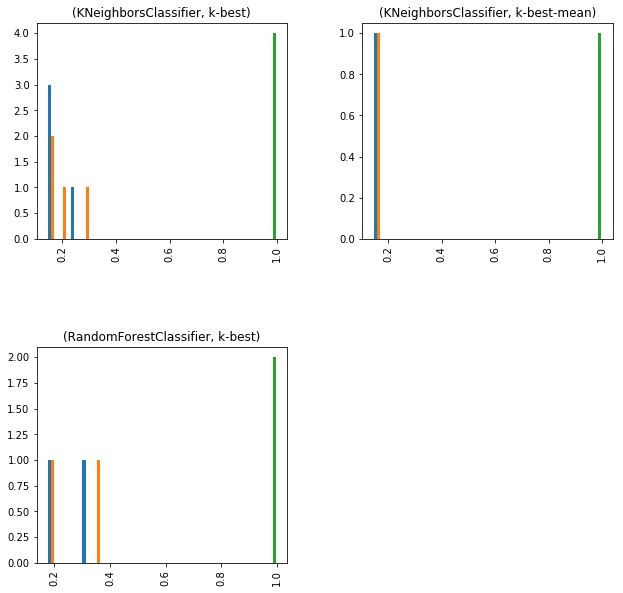

In [153]:
df.hist(bins=20, by=['model', 'feature_selector'], figsize=(10,10))